<a href="https://colab.research.google.com/github/rishit020/rishit-ml-portfolio/blob/main/supervised-learning/HousePrice_XGBoost/HousePrice_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Prediction with XGBoost
Predicting housing prices using tabular data. Includes:
- Missing value imputation
- Feature preprocessing (numerical + categorical)
- XGBoost regression with cross-validation
- Train/Test evaluation

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.drop(['Order', 'PID'], axis=1, inplace=True)

In [ ]:
df['Alley'] = df['Alley'].fillna('NoAlley')
df['Pool QC'] = df['Pool QC'].fillna('NoPool')
df['Fence'] = df['Fence'].fillna('NoFence')
df['Misc Feature'] = df['Misc Feature'].fillna('None')
df['Mas Vnr Type'] = df['Mas Vnr Type'].fillna('None')
df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0)
df['Fireplace Qu'] = df['Fireplace Qu'].fillna('NoFireplace')
df['Bsmt Full Bath'] = df['Bsmt Full Bath'].replace('NoBasement', 0).fillna(0).astype(float)
df['Bsmt Half Bath'] = df['Bsmt Half Bath'].replace('NoBasement', 0).fillna(0).astype(float)

In [ ]:
df["Lot Frontage"] = (
    df.groupby("Neighborhood")["Lot Frontage"]
      .transform(lambda x: x.fillna(x.median()))
)

In [ ]:
bsmt_columns_fill_none = [
    "Bsmt Qual",
    "Bsmt Cond",
    "Bsmt Exposure",
    "BsmtFin Type 1",
    "BsmtFin Type 2",
    ]

bsmt_columns_fill_0 = [
    "BsmtFin SF 1",
    "BsmtFin SF 2",
    "Bsmt Unf SF",
    "Total Bsmt SF"]

for col in bsmt_columns_fill_none:
  df[col] = df[col].fillna('NoBasement')

for col1 in bsmt_columns_fill_0:
  df[col1] = df[col1].fillna(0)

In [ ]:
garage_col_fill_none = ['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']

garage_col_fill_0 = ['Garage Yr Blt', 'Garage Cars', 'Garage Area']

for col2 in garage_col_fill_none:
  df[col2] = df[col2].fillna('NoGarage')

for col3 in garage_col_fill_0:
  df[col3] = df[col3].fillna(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      2930 non-null   int64  
 1   MS Zoning        2930 non-null   object 
 2   Lot Frontage     2927 non-null   float64
 3   Lot Area         2930 non-null   int64  
 4   Street           2930 non-null   object 
 5   Alley            2930 non-null   object 
 6   Lot Shape        2930 non-null   object 
 7   Land Contour     2930 non-null   object 
 8   Utilities        2930 non-null   object 
 9   Lot Config       2930 non-null   object 
 10  Land Slope       2930 non-null   object 
 11  Neighborhood     2930 non-null   object 
 12  Condition 1      2930 non-null   object 
 13  Condition 2      2930 non-null   object 
 14  Bldg Type        2930 non-null   object 
 15  House Style      2930 non-null   object 
 16  Overall Qual     2930 non-null   int64  
 17  Overall Cond  

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,141.0,31770,Pave,NoAlley,IR1,Lvl,AllPub,Corner,...,0,NoPool,NoFence,None,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NoAlley,Reg,Lvl,AllPub,Inside,...,0,NoPool,MnPrv,None,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NoAlley,IR1,Lvl,AllPub,Corner,...,0,NoPool,NoFence,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NoAlley,Reg,Lvl,AllPub,Corner,...,0,NoPool,NoFence,None,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NoAlley,IR1,Lvl,AllPub,Inside,...,0,NoPool,MnPrv,None,0,3,2010,WD,Normal,189900


In [ ]:
x = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=41)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:
num_cols = x.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = x.select_dtypes(include=["object"]).columns.tolist()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

In [92]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=1000,          # slightly more trees, but controlled with early stopping
        learning_rate=0.05,        # slow learning rate for stable training
        max_depth=3,               # shallower trees to reduce overfitting
        subsample=0.8,             # row sampling for regularization
        colsample_bytree=0.8,      # feature sampling for regularization
        reg_alpha=1,               # L1 regularization
        reg_lambda=1,              # L2 regularization
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ))
])

In [93]:
r2_scores = cross_val_score(
        pipeline,
        x_train,
        y_train,
        cv=5,
        scoring="r2"
    )

print(f"XGBRegressor CV R²: {r2_scores.mean():.4f}")


rmse_scores = -cross_val_score(
    pipeline, x_train, y_train, cv=5, scoring="neg_root_mean_squared_error"
)
print(f"XGBRegressor CV RMSE: {rmse_scores.mean():.2f}")

mse_scores = -cross_val_score(
    pipeline, x_train, y_train, cv=5, scoring="neg_mean_squared_error"
)
print(f"XGBRegressor CV MSE: {mse_scores.mean():.2f}")

XGBRegressor CV R²: 0.9146
XGBRegressor CV RMSE: 23668.81
XGBRegressor CV MSE: 580520134.40


In [94]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['MS SubClass',
                                                   'Lot Frontage', 'Lot Area',
                                                   'Overall Qual',
                                                   'Overall Cond', 'Year Built',
                                                   'Year Remod/Add',
                                                   'Mas Vnr Area',
                                                   'BsmtFin SF 1',
                                                   'BsmtFin SF 2',
                                                   'Bsmt Unf SF',
                                                   'Total Bsmt SF',
                                                   '1st Flr SF', '2nd Flr SF',
                                                   'Low Qual Fin SF',
                                                   'Gr Liv Area',
                                                   'Bsmt Full Bath',
                                                   'Bsmt Half Bath',...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [95]:
y_train_pred = pipeline.predict(x_train)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)

print(f"Train R²: {train_r2:.4f}")
print(f"Train MSE: {train_mse:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")

Train R²: 0.9892
Train MSE: 72785120.00
Train RMSE: 8531.42
Train MAE: 6482.31


In [96]:
y_test_pred = pipeline.predict(x_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")

Test R²: 0.9226
Test MSE: 379418592.00
Test RMSE: 19478.67
Test MAE: 12875.93


### True vs. Predicted Values Plot

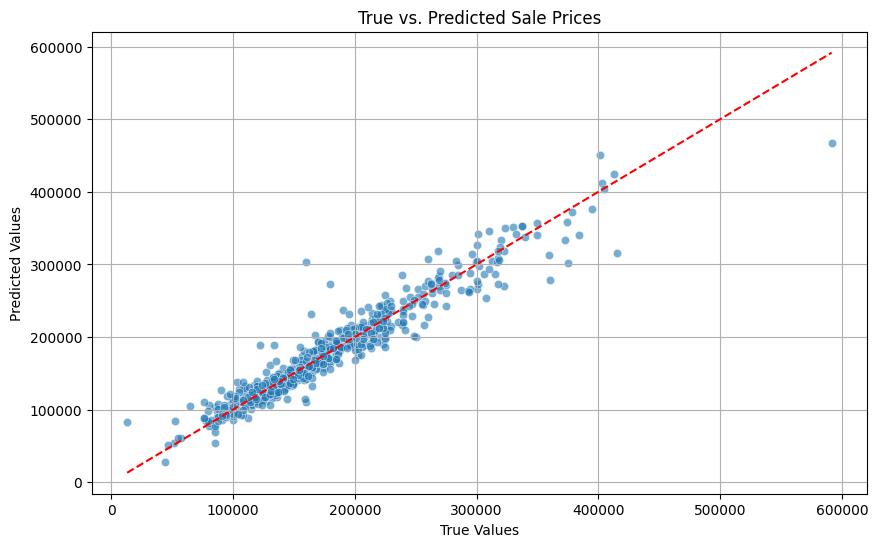

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # Red dashed line for ideal prediction
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Sale Prices')
plt.grid(True)
plt.show()

### XGBoost Feature Importance

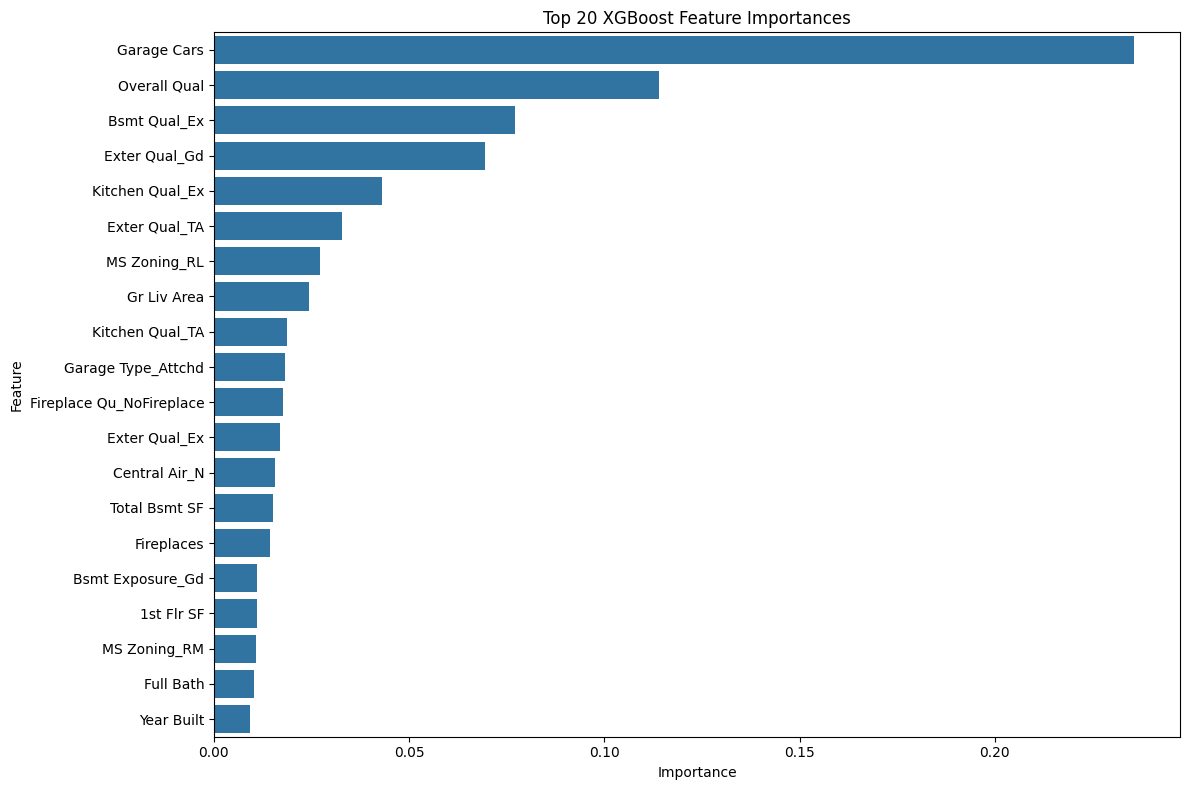

In [98]:
# Get feature importances from the trained XGBoost model
feature_importances = pipeline['model'].feature_importances_

# Get feature names after preprocessing
preprocessor = pipeline.named_steps['preprocessor']

# Get numerical feature names
num_feature_names = num_cols

# Get categorical feature names after one-hot encoding
cat_transformer = preprocessor.named_transformers_['cat']
cat_feature_names = cat_transformer.get_feature_names_out(cat_cols).tolist()

# Combine all feature names
all_feature_names = num_feature_names + cat_feature_names

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort by importance and select top N features
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 20 XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Residual Distribution Plot

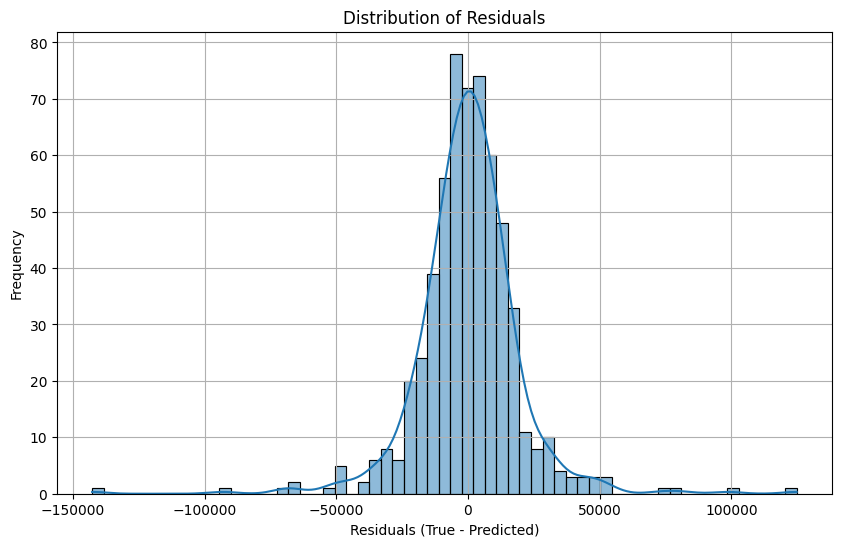

In [99]:
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals (True - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()